<a href="https://colab.research.google.com/github/johanamcr/RetoCAMAMA/blob/main/support_vector_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modeling de Cancer de Mama

Se prueban inicialmente bajo un train/validation/split los modelos de:

Ahora iniciaremos con modelos de ensamble

  * SVC

Y ejecutaremos los visto en las clases anteriores

  * Regresión Logística
  * Knn
  * CART
  * ID3
  * CHAID
  * Bagging
  * Random Forest
  * AdaBoost
  * XGBoost
  * LightGBM

In [ ]:
# Upload your kaggle.json file (contains API key)
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"danipipe777","key":"5f9066e7b2a5b13bcb2554c8a4d363f0"}'}

In [ ]:
# Make directory and move kaggle.json
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

# Set permissions
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c fa-i-2025-i-modelos-tradicionales-ca-mamaII

!unzip fa-i-2025-i-modelos-tradicionales-ca-mamaII

Archive:  fa-i-2025-i-modelos-tradicionales-ca-mamaII.zip
  inflating: Diccionario.xlsx        
  inflating: df_test.parquet         
  inflating: df_train.parquet        
  inflating: sample_submission.csv   


## Importamos Librerias

In [ ]:
import numpy as np  # Algebra lineal, manipulación de arreglos numéricos.
import pandas as pd  # Procesamiento de datos, lectura/escritura de archivos CSV.
import os.path as osp  # Manejo de rutas de archivos.
import pickle  # Serialización y deserialización de objetos Python (guardar/cargar modelos).


# Modelos de clasificación Adicional

from sklearn.svm import SVC

# Modelos de clasificación
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn import tree
from sklearn.linear_model import LogisticRegression  # Modelo de regresión logística para clasificación binaria.
from sklearn.neighbors import KNeighborsClassifier  # K-Nearest Neighbors (KNN) para clasificación basada en distancia.
from sklearn.naive_bayes import GaussianNB  # Clasificador Naive Bayes basado en distribución Gaussiana.

# Preprocesamiento de datos
from sklearn.preprocessing import OneHotEncoder  # Codificación one-hot para variables categóricas nominales.
from sklearn.preprocessing import OrdinalEncoder  # Codificación ordinal para variables categóricas con orden.
from sklearn.preprocessing import StandardScaler  # Normalización de datos para mejorar el rendimiento del modelo.
from sklearn.preprocessing import FunctionTransformer  # Aplicación de transformaciones personalizadas.

# División del conjunto de datos
from sklearn.model_selection import train_test_split  # División en conjunto de entrenamiento y prueba.

# Selección de características
from sklearn.feature_selection import VarianceThreshold  # Elimina características con varianza baja (irrelevantes).
from sklearn.feature_selection import SelectPercentile, chi2  # Selección de características más relevantes con Chi-cuadrado.

# Construcción del pipeline de procesamiento y modelado
from sklearn.compose import ColumnTransformer  # Aplica transformaciones específicas a diferentes columnas.
from sklearn.pipeline import Pipeline, make_pipeline  # Automatiza el flujo de preprocesamiento y modelado.

# Manejo de valores faltantes
from sklearn.impute import SimpleImputer  # Rellena valores faltantes con media, mediana, moda, etc.

# Evaluación de modelos
import sklearn.metrics as skm  # Métricas de rendimiento como precisión, recall, F1-score, AUC-ROC, etc.

# Visualización de datos
import matplotlib.pyplot as plt  # Gráficos y visualización de métricas.
import seaborn as sns  # Visualización avanzada con gráficos estadísticos.

# Medición de tiempos de ejecución
from time import time  # Captura de tiempo de inicio y fin de ejecución.
from datetime import timedelta  # Cálculo de diferencias de tiempo en ejecución.

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Funciones útiles

In [ ]:
def get_imbalaced_metrics(y_true, y_preds):
    '''calcula métricas de evaluación para modelos de clasificación cuando los datos están desbalanceados.'''
    ths = np.linspace(0, 1, 1000)
    best_th = ths[
        np.argmax([skm.f1_score(y_true, y_preds>th) for th in ths])
    ]

    roc_auc = skm.roc_auc_score(y_true, y_preds)
    average_precision = skm.average_precision_score(y_true, y_preds)
    max_f1 = skm.f1_score(y_true, y_preds>best_th)
    accuracy_on_max_f1 = skm.accuracy_score(y_true, y_preds>best_th)
    kappa = skm.cohen_kappa_score(y_true, y_preds>best_th)
    baseline=y_true.value_counts(True)


    return dict(
        roc_auc=roc_auc,
        average_precision=average_precision,
        max_f1=max_f1,
        accuracy_on_max_f1=accuracy_on_max_f1,
        kappa=kappa,
        baseline=baseline.iloc[0],
        best_th = best_th
    )

## Carga de Datos

Este fragmento de código carga los datos del conjunto de entrenamiento (df_train.parquet) desde un directorio en Kaggle.

In [ ]:
df = pd.read_parquet("df_train.parquet")
df.head()

,GENERO,ESTADO_CIVIL,FECHA_NACIMIENTO,CODIGO_SEDE,MULTI_CANCER,CESION,RIESGOS,CANCER_MAMA_FAMILIAR,CANCER_OTRO_SITIO,CANCER_OTRO_SITIO_FAMILIAR,...,radioterapias_cancer,quimioterapias__cancer,hormonoterapias__cancer,cuidado_palitiavo__cancer,inmunoterapias_cancer,Citas_oncologicas_cancer,psiquiatria_cancer,psicologia_cancer,nutricion_cancer,atencion_nutricion
ID,,,,,,,,,,,,,,,,,,,,,
2987,F,SO,1977-01-17,1051,None,0,2.0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,Sin servicios nutricion
3423,F,CA,1980-10-13,1028,None,0,1.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,5.0,1.0,1.0,0.0,Sin servicios nutricion
6981,F,SO,1951-10-28,1022,None,0,3.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Una servicio nutricion
6701,F,SO,1984-03-31,1026,None,0,1.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,Sin servicios nutricion
7361,F,UL,1974-03-28,1007,None,0,1.0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,Sin servicios nutricion


Separamos las características (X) y la variable objetivo (y) del conjunto de datos, y luego analiza el balance de clases en la variable objetivo. Del EDA realizado anteriormente ya sabiamos del desbalanceo de nuestra variable objetivo, un 11% de complicaciones.

In [ ]:
X, y = df.drop(columns="Target"), df["Target"]
y.value_counts(True) * 100

,proportion
Target,
0.0,88.697851
1.0,11.302149


Calculamos la edad de los pacientes al momento de la complicación o corte del analisis.

In [ ]:
X['EDAD_COMPLICACION'] = (X['Fecha_cero'] - X['FECHA_NACIMIENTO']).dt.days // 365

Validamos las variables que tienen mucha nulidad ¿La quitamos? o que nos dice el negocio? Esto es importante para la limpieza y preprocesamiento de datos antes de entrenar modelos de clasificación.

In [ ]:
porcetaje_de_nulidad = (
    X.isnull()
    .apply(lambda s: s.value_counts(True)).T
)

porcetaje_de_nulidad.columns = ['not_null', 'null']
variables_muy_nulas = porcetaje_de_nulidad.query('null > 0.7').index

Por conocimiento de negocio, se cambian los tipos de algunas variables

In [ ]:
columnas_numerico=['MULTI_CANCER','RIESGOS']
X[columnas_numerico] = X[columnas_numerico].astype(float)

columnas_categ= ['GENERO','ESTADO_CIVIL',
                 'CESION','CANCER_MAMA_FAMILIAR',
                'CANCER_OTRO_SITIO','CANCER_OTRO_SITIO_FAMILIAR','CEREBRAL_FAMILIAR'
                ,'atencion_nutricion'
                ]
X[columnas_categ] = X[columnas_categ].astype(str)

Dividimos el conjunto de datos en entrenamiento y prueba, por ahora, sin implementar un protocolo complejo de evaluación.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)


Validemos que tan desbalanceados quedaron los particionamientos

In [ ]:
print(y_train.value_counts(True)*100)
print(y_test.value_counts(True)*100)

Target
0.0    88.693841
1.0    11.306159
Name: proportion, dtype: float64
Target
0.0    88.720539
1.0    11.279461
Name: proportion, dtype: float64


### Pipeline

Este fragmento de código separa las variables en categóricas y numéricas, eliminando aquellas que tienen más del 70% de valores nulos (almacenadas en variables_muy_nulas).

In [ ]:
##Selecciona las columnas categóricas (variables tipo object o cadenas de texto) en X_train.
categoricas = X_train.select_dtypes('object').columns
categoricas = categoricas.delete(
    categoricas.isin(variables_muy_nulas)
)

##Selecciona las columnas numéricas en X_train (variables tipo int o float).
numericas = X_train.select_dtypes('number').columns
numericas = numericas.delete(
    numericas.isin(variables_muy_nulas)
)

Configuración para el codificador One-Hot (OneHotEncoder) en el preprocesamiento de variables categóricas.

In [ ]:
config_onehot = dict(
    handle_unknown='ignore' # Ignora cualquier categoría desconocida que aparezca en los datos de prueba pero que no estaba en los datos de entrenamiento.
)

In [ ]:
numeric_transformer = Pipeline(
    steps=[("imputer",  SimpleImputer(strategy='mean')),
           ("scaler", StandardScaler()),
           ("select_var", VarianceThreshold(0.1))
           ]
)

categorical_transformer = Pipeline(
    steps=[('imputer', SimpleImputer(strategy='most_frequent')),
           ('dumm', OneHotEncoder(**config_onehot)),
           ("selector", SelectPercentile(chi2, percentile=50))
           ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numericas),
        ("cat", categorical_transformer, categoricas),
    ]
)

## SVC

In [ ]:
svc_pipeline = Pipeline([
    ('preprocesamiento', preprocessor),
    ('classificador', SVC(kernel='rbf', C=1.0, probability=True)) #RBF, Linear, sigmoid
])

start = time()
svc_pipeline.fit(X_train, y_train)
end = time()

print(
    'Tiempo Entrenamiento Regresión Logistica:',
    str(timedelta(seconds=end-start))
)

Tiempo Entrenamiento Regresión Logistica: 0:00:02.723768


In [ ]:
svc_val_preds = svc_pipeline.predict_proba(X_test)[:, 1]
svc_metrics = get_imbalaced_metrics(y_test, svc_val_preds)
svc_metrics

{'roc_auc': np.float64(0.783284714945198),
 'average_precision': np.float64(0.5399476079421451),
 'max_f1': 0.5360824742268041,
 'accuracy_on_max_f1': 0.9242424242424242,
 'kappa': np.float64(0.5012873614687116),
 'baseline': np.float64(0.8872053872053872),
 'best_th': np.float64(0.47147147147147145)}

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

## Ejecutemos los que ya vimos

In [ ]:
numeric_transformer = Pipeline(
    steps=[("imputer",  SimpleImputer(strategy='mean')),
           ("select_var", VarianceThreshold(0.1))
           ]
)

categorical_transformer = Pipeline(
    steps=[('imputer', SimpleImputer(strategy='most_frequent')),
           ('dumm', OneHotEncoder(**config_onehot)),
           ]
)

tree_preprocessing = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numericas),
        ("cat", categorical_transformer, categoricas),
    ]
)

### Bagging

In [ ]:
config_bagging = dict(
    n_estimators=300,          # Número de modelos a crear
                    max_samples=0.5,          # Número o % de registros de la muestra de aprendizaje
                    max_features=0.5,         # Número o % de atributos de la muestra de aprendizaje
                    bootstrap=True,           # Utilizar reemplazo en el muestreo de los registros de aprendizaje
                    bootstrap_features=False, # Utilizar reemplazo en el muestreo de los atributos de aprendizaje
                    oob_score=False,          # Evaluar cada modelo con los registros no utilizados en su aprendizaje
                    n_jobs=2,                 # Número de cores a utilizar
                    verbose=0
)

bagging_pipeline = Pipeline([
    ('preprocesamiento', tree_preprocessing),
    ('classificador', BaggingClassifier(**config_bagging))
])

start = time()
bagging_pipeline.fit(X_train, y_train)
end = time()

print(
    'Tiempo Entrenamiento bagging:',
    str(timedelta(seconds=end-start))
)

Tiempo Entrenamiento bagging: 0:00:08.800948


In [ ]:
bagging_val_preds = bagging_pipeline.predict_proba(X_test)[:, 1]
bagging_metrics = get_imbalaced_metrics(y_test, bagging_val_preds)
bagging_metrics

{'roc_auc': np.float64(0.8575150811407856),
 'average_precision': np.float64(0.6084360827746997),
 'max_f1': 0.56,
 'accuracy_on_max_f1': 0.9259259259259259,
 'kappa': np.float64(0.524609843937575),
 'baseline': np.float64(0.8872053872053872),
 'best_th': np.float64(0.4174174174174174)}

Probá cambiando los hiperparametros!
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html

## Random Forest

In [ ]:
rf_pipeline = Pipeline([
    ('preprocesamiento', tree_preprocessing),
    ('classificador', RandomForestClassifier())
])

start = time()
rf_pipeline.fit(X_train, y_train)
end = time()

print(
    'Tiempo Entrenamiento RandomForest:',
    str(timedelta(seconds=end-start))
)

Tiempo Entrenamiento RandomForest: 0:00:02.173292


In [ ]:
rf_val_preds = rf_pipeline.predict_proba(X_test)[:, 1]
rf_metrics = get_imbalaced_metrics(y_test, rf_val_preds)
rf_metrics

{'roc_auc': np.float64(0.8487779319720185),
 'average_precision': np.float64(0.6052331321782467),
 'max_f1': 0.5567010309278351,
 'accuracy_on_max_f1': 0.9276094276094277,
 'kappa': np.float64(0.5234523676256577),
 'baseline': np.float64(0.8872053872053872),
 'best_th': np.float64(0.5205205205205206)}

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

## ADA Boosting

In [ ]:
config_ada = dict(#estimator=None,  #Por defecto se trata de decision stumps
    n_estimators=100,     #Número de modelos a crear
    algorithm='SAMME',
    learning_rate=1.0
)

ada_pipeline = Pipeline([
    ('preprocesamiento', tree_preprocessing),
    ('classificador', AdaBoostClassifier(**config_ada)  )  #Reduce la importancia de los modelos mas recientes)
])

start = time()
ada_pipeline.fit(X_train, y_train)
end = time()

print(
    'Tiempo Entrenamiento ADA Boosting:',
    str(timedelta(seconds=end-start))
)


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


Tiempo Entrenamiento ADA Boosting: 0:00:02.317697


In [ ]:
ada_val_preds = ada_pipeline.predict_proba(X_test)[:, 1]
ada_metrics = get_imbalaced_metrics(y_test, ada_val_preds)
ada_metrics

{'roc_auc': np.float64(0.8723554901016738),
 'average_precision': np.float64(0.5874262079950228),
 'max_f1': 0.5454545454545454,
 'accuracy_on_max_f1': 0.9242424242424242,
 'kappa': np.float64(0.509703217286034),
 'baseline': np.float64(0.8872053872053872),
 'best_th': np.float64(0.4934934934934935)}

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html

## XGBoost

In [ ]:
config_xgb = dict(
    use_label_encoder=False, eval_metric='logloss'
)

xgb_pipeline = Pipeline([
    ('preprocesamiento', tree_preprocessing),
    ('classificador', XGBClassifier(**config_xgb))
])

start = time()
xgb_pipeline.fit(X_train, y_train)
end = time()

print(
    'Tiempo Entrenamiento XGBoost:',
    str(timedelta(seconds=end-start))
)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:16:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Tiempo Entrenamiento XGBoost: 0:00:00.415033


In [ ]:
xgb_val_preds = xgb_pipeline.predict_proba(X_test)[:, 1]
xgb_metrics = get_imbalaced_metrics(y_test, xgb_val_preds)
xgb_metrics

{'roc_auc': np.float64(0.866379676569713),
 'average_precision': np.float64(0.6150415918199621),
 'max_f1': 0.5686274509803921,
 'accuracy_on_max_f1': 0.9259259259259259,
 'kappa': np.float64(0.5324340763533579),
 'baseline': np.float64(0.8872053872053872),
 'best_th': np.float64(0.48148148148148145)}

https://xgboost.readthedocs.io/en/stable/get_started.html

## Arboles

### ID3

In [ ]:
config_ctree = dict(criterion='entropy', # el criterio de particionamiento de un conjunto de datos (gini, entropy)
        #    max_depth=None,      # prepoda: controla la profundidad del árbol (largo máximo de las ramas)
        #    min_samples_split=2, # prepoda: el mínimo número de registros necesarios para crear una nueva rama
        #    min_samples_leaf=1,  # prepoda: el mínimo número de registros en una hoja
        #    random_state=None,   # semilla del generador aleatorio utilizado para
        #    max_leaf_nodes=None, # prepoda: máximo número de nodos hojas
        #    min_impurity_decrease=0.0 # prepoda: umbral mínimo de reducción de la impureza para aceptar la creación de una rama
)

ctree_id3_pipeline = Pipeline([
    ('preprocesamiento', tree_preprocessing),
    ('classificador', tree.DecisionTreeClassifier(**config_ctree
            ))
])

start = time()
ctree_id3_pipeline.fit(X_train, y_train)
end = time()

print(
    'Tiempo Entrenamiento ctree_id3:',
    str(timedelta(seconds=end-start))
)

Tiempo Entrenamiento ctree_id3: 0:00:00.200299


In [ ]:
ctree_id3_val_preds = ctree_id3_pipeline.predict_proba(X_test)[:, 1]
ctree_id3_metrics = get_imbalaced_metrics(y_test, ctree_id3_val_preds)
ctree_id3_metrics

{'roc_auc': np.float64(0.7027528392194624),
 'average_precision': np.float64(0.2772594459161623),
 'max_f1': 0.46715328467153283,
 'accuracy_on_max_f1': 0.877104377104377,
 'kappa': np.float64(0.3977332703686214),
 'baseline': np.float64(0.8872053872053872),
 'best_th': np.float64(0.0)}

### CART

In [ ]:
config_ctree_cart = dict(criterion='gini', # el criterio de particionamiento de un conjunto de datos (gini, entropy)
        #    max_depth=None,      # prepoda: controla la profundidad del árbol (largo máximo de las ramas)
        #    min_samples_split=2, # prepoda: el mínimo número de registros necesarios para crear una nueva rama
        #    min_samples_leaf=1,  # prepoda: el mínimo número de registros en una hoja
        #    random_state=None,   # semilla del generador aleatorio utilizado para
        #    max_leaf_nodes=None, # prepoda: máximo número de nodos hojas
        #    min_impurity_decrease=0.0 # prepoda: umbral mínimo de reducción de la impureza para aceptar la creación de una rama
)

ctree_cart_pipeline = Pipeline([
    ('preprocesamiento', tree_preprocessing),
    ('classificador', tree.DecisionTreeClassifier(**config_ctree_cart
            ))
])

start = time()
ctree_cart_pipeline.fit(X_train, y_train)
end = time()

print(
    'Tiempo Entrenamiento ctree_cart:',
    str(timedelta(seconds=end-start))
)

Tiempo Entrenamiento ctree_cart: 0:00:00.160681


In [ ]:
ctree_cart_val_preds = ctree_cart_pipeline.predict_proba(X_test)[:, 1]
ctree_cart_metrics = get_imbalaced_metrics(y_test, ctree_cart_val_preds)
ctree_cart_metrics

{'roc_auc': np.float64(0.6710045597439745),
 'average_precision': np.float64(0.23773733826411614),
 'max_f1': 0.4148148148148148,
 'accuracy_on_max_f1': 0.867003367003367,
 'kappa': np.float64(0.3397957173809055),
 'baseline': np.float64(0.8872053872053872),
 'best_th': np.float64(0.0)}

Probá cambiando los hiperparametros!

https://scikit-learn.org/stable/modules/tree.html

### Incluir CHAID

In [ ]:
numeric_transformer = Pipeline(
    steps=[("imputer",  SimpleImputer(strategy='mean')),
           ("scaler", StandardScaler()),
           ("select_var", VarianceThreshold(0.1))
           ]
)

categorical_transformer = Pipeline(
    steps=[('imputer', SimpleImputer(strategy='most_frequent')),
           ('dumm', OneHotEncoder(**config_onehot)),
           ("selector", SelectPercentile(chi2, percentile=50))
           ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numericas),
        ("cat", categorical_transformer, categoricas),
    ]
)

## Regresión Logistica

In [ ]:
rl_pipeline = Pipeline([
    ('preprocesamiento', preprocessor),
    ('classificador', LogisticRegression())
])

start = time()
rl_pipeline.fit(X_train, y_train)
end = time()

print(
    'Tiempo Entrenamiento Regresión Logistica:',
    str(timedelta(seconds=end-start))
)

Tiempo Entrenamiento Regresión Logistica: 0:00:00.144512


In [ ]:
rl_val_preds = rl_pipeline.predict_proba(X_test)[:, 1]
rl_metrics = get_imbalaced_metrics(y_test, rl_val_preds)
rl_metrics

{'roc_auc': np.float64(0.8120026055679854),
 'average_precision': np.float64(0.5854619335251826),
 'max_f1': 0.5522388059701493,
 'accuracy_on_max_f1': 0.898989898989899,
 'kappa': np.float64(0.49531280976521563),
 'baseline': np.float64(0.8872053872053872),
 'best_th': np.float64(0.20020020020020018)}

Probá cambiando los hiperparametros!

https://scikit-learn.org/0.16/modules/generated/sklearn.linear_model.LogisticRegression.html

## KNN

In [ ]:
knn_pipeline = Pipeline([
    ('preprocesamiento', preprocessor),
    ('classificador', KNeighborsClassifier(n_neighbors=11))
])

start = time()
knn_pipeline.fit(X_train, y_train)
end = time()

print(
    'Tiempo Entrenamiento Knn:',
    str(timedelta(seconds=end-start))
)

Tiempo Entrenamiento Knn: 0:00:00.043123


In [ ]:
knn_val_preds = knn_pipeline.predict_proba(X_test)[:, 1]
knn_metrics = get_imbalaced_metrics(y_test, knn_val_preds)
knn_metrics

{'roc_auc': np.float64(0.835438556741907),
 'average_precision': np.float64(0.520188208533248),
 'max_f1': 0.5,
 'accuracy_on_max_f1': 0.8888888888888888,
 'kappa': np.float64(0.43751614106574077),
 'baseline': np.float64(0.8872053872053872),
 'best_th': np.float64(0.18218218218218218)}


Probá cambiando los hiperparametros! Si, cambia de vecinos

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

## Naive Bayes

In [ ]:
nb_pipeline = Pipeline([
    ('preprocesamiento', preprocessor),
    ('classificador', GaussianNB())
])

start = time()
nb_pipeline.fit(X_train, y_train)
end = time()

print(
    'Tiempo Entrenamiento nb:',
    str(timedelta(seconds=end-start))
)

Tiempo Entrenamiento nb: 0:00:00.050617


In [ ]:
nb_val_preds = nb_pipeline.predict_proba(X_test)[:, 1]
nb_metrics = get_imbalaced_metrics(y_test, nb_val_preds)
nb_metrics

{'roc_auc': np.float64(0.48591010790450023),
 'average_precision': np.float64(0.10968327869999814),
 'max_f1': 0.20100502512562815,
 'accuracy_on_max_f1': 0.19696969696969696,
 'kappa': np.float64(0.000916790668481382),
 'baseline': np.float64(0.8872053872053872),
 'best_th': np.float64(0.998998998998999)}

Probá cambiando los hiperparametros! Umm, no aqui nada que hacer

## Resumen Metricas

In [ ]:
metrics = dict(
    knn=knn_metrics,
    rl=rl_metrics,
    nb=nb_metrics,
    ctree_cart=ctree_cart_metrics,
    ctree_id3=ctree_id3_metrics,
    bagging=bagging_metrics,
    ada=ada_metrics,
    rf=rf_metrics,
    xgboost=xgb_metrics,
    svc=svc_metrics
)

df_metrics = pd.DataFrame.from_dict(metrics, orient='index')

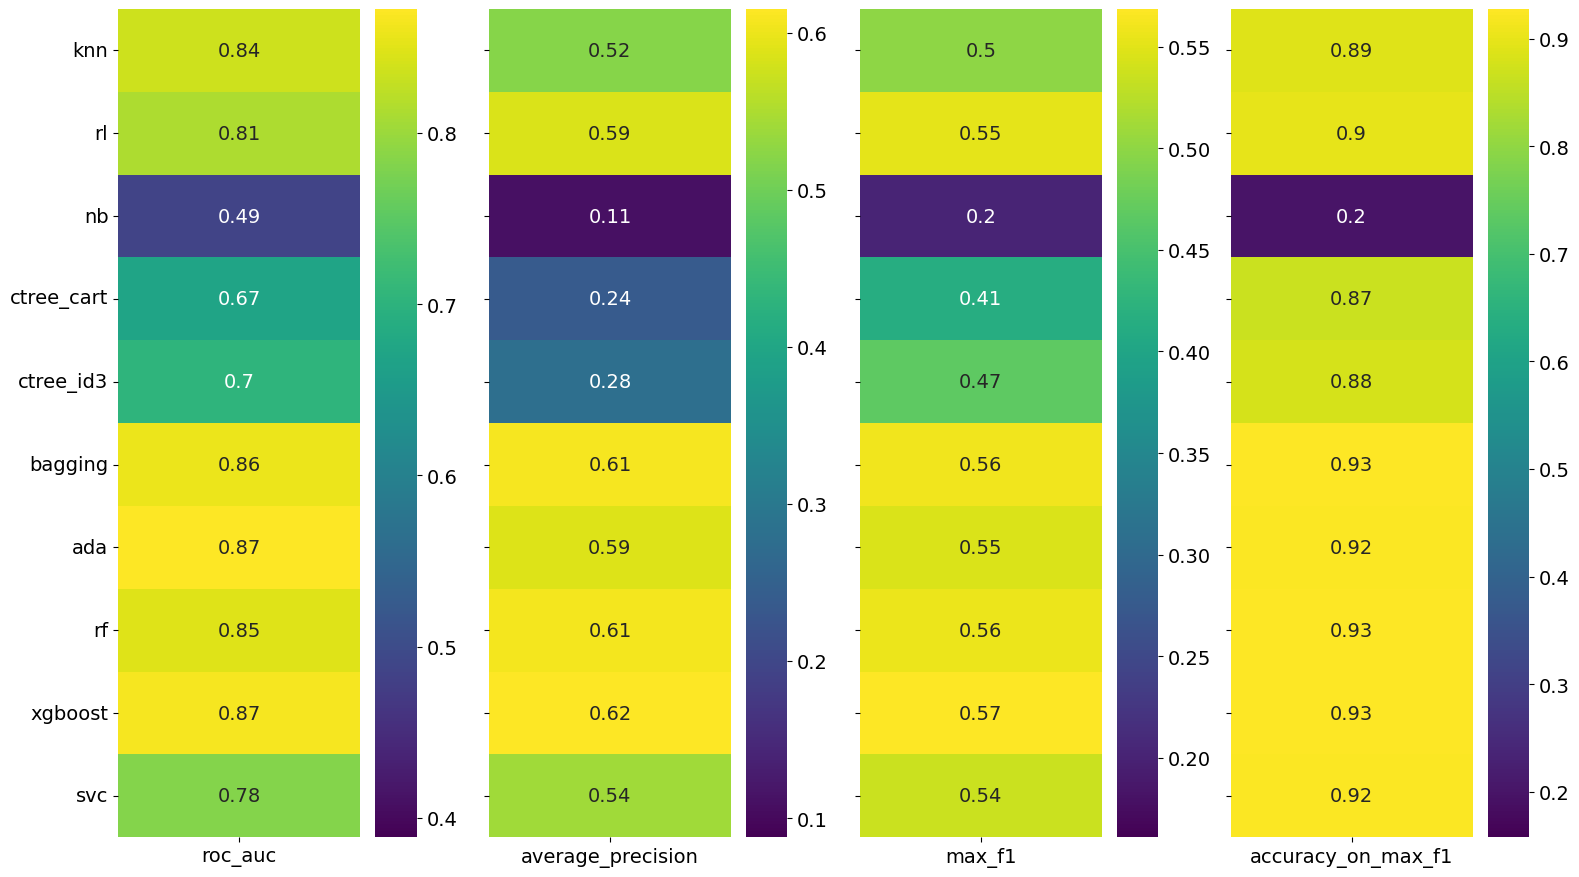

In [ ]:
plt.rc('font', size=14)
plt.rc('xtick', labelsize=14)

fig, axs = plt.subplots(1, 4 , figsize=(16, 9), sharey=True)

for i, ax in enumerate(axs):
    sns.heatmap(
        df_metrics.iloc[:, [i]],
        ax=ax,
        vmin=df_metrics.iloc[:, [i]].min()*0.8,
        vmax=df_metrics.iloc[:, [i]].max(),
        annot=True,
        cmap='viridis'
    )

fig.tight_layout()

Definamos el umbral de decisión.

https://towardsdatascience.com/metrics-to-evaluate-your-machine-learning-algorithm-f10ba6e38234

https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

https://www.analyticsvidhya.com/blog/2019/08/11-important-model-evaluation-error-metrics/

## Supongamos que el mejor modelo fue SVC

In [ ]:
ths = np.linspace(0, 1, 1000)
best_th = ths[np.argmax([skm.f1_score(y_test, svc_val_preds>th) for th in ths])]
best_th

np.float64(0.47147147147147145)

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid = {
    'classificador__kernel': ['linear', 'rbf'], #, 'poly'
    'classificador__C': [0.1, 1, 10],
    'classificador__gamma': ['scale', 'auto', 0.01, 0.1, 1],  # gamma solo aplica a kernels no lineales
    #'classificador__degree': [2, 3, 4]  # solo para 'poly'
}

In [ ]:
grid_search = GridSearchCV(
    estimator=svc_pipeline,
    param_grid=param_grid,
    scoring='f1',   #
    cv=3,                 # k-fold cross-validation
    verbose=2,            # para que veas el progreso
    n_jobs=-1             # usa todos los núcleos disponibles
)

In [ ]:
# Entrenamiento con cronómetro
start = time()
grid_search.fit(X_train, y_train)
end = time()

Fitting 3 folds for each of 30 candidates, totalling 90 fits


In [ ]:
print('Mejores hiperparámetros encontrados:', grid_search.best_params_)
print('Mejor score (f1):', grid_search.best_score_)

Mejores hiperparámetros encontrados: {'classificador__C': 10, 'classificador__gamma': 'auto', 'classificador__kernel': 'rbf'}
Mejor score (f1): 0.4697523864331273


Espera!! Deberiamos reentrenar con todos los datos?

In [ ]:
# Tomar el mejor modelo
best_model = grid_search.best_estimator_

# Reentrenar con TODOS los datos (X e y completos)
best_model.fit(X, y)

Pipeline(steps=[('preprocesamiento',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('select_var',
                                                                   VarianceThreshold(threshold=0.1))]),
                                                  Index(['RIESGOS', 'PESO', 'TALLA', 'TSISTOLICA', 'TDIASTOLICA', 'mes_6',
       'mes_5', 'mes_4', 'mes_3', 'mes_2', 'mes_1', 'valor_servicio',
       'IV_NIVEL', 'HOSPI_NO_QUIRURGI...
                                                                   OneHotEncoder(handle_unknown='ignore')),
                                                                  ('selector',
                                                                   SelectPercentile(percentile=50,
                                                                                    score_func=<function chi2 at 0x7d90b479b600>))]),
                                                  Index(['GENERO', 'ESTADO_CIVIL', 'CODIGO_SEDE', 'CESION',
       'CANCER_MAMA_FAMILIAR', 'CANCER_OTRO_SITIO',
       'CANCER_OTRO_SITIO_FAMILIAR', 'CEREBRAL_FAMILIAR',
       'atencion_nutricion'],
      dtype='object'))])),
                ('classificador', SVC(C=10, gamma='auto', probability=True))])

In [ ]:
with open("best_model.pkl", "wb") as f:
    pickle.dump(svc_pipeline, f)

## Generar Submission

Realicemos predicciones sobre el test set de la competencia

In [ ]:
test_df = pd.read_parquet( "df_test.parquet")
test_df['EDAD_COMPLICACION'] = (test_df['Fecha_cero'] - test_df['FECHA_NACIMIENTO']).dt.days // 365

test_df[columnas_numerico] = X[columnas_numerico].astype(float)
test_df[columnas_categ] = X[columnas_categ].astype(str)

submission_pred = best_model.predict_proba(test_df)[:, 1]
submission_pred_bool = submission_pred>best_th
submission_pred_int = [int(item) for item in submission_pred_bool]
submission = pd.DataFrame(data=dict(ID=test_df.index, Target=submission_pred_int))
submission.to_csv("submission_svc.csv", index=False)

In [ ]:
submission.Target.value_counts()

,count
Target,
0,1607
1,88
